In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano
import theano.tensor as tt


random_state = np.random.RandomState(42)

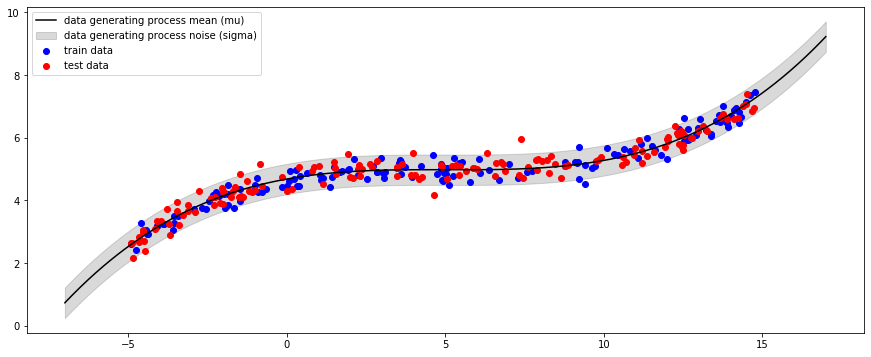

In [2]:
# make data

def fake_model(x):
    return x**3 - x

num_samples = 150
scale_factor = 100

x_train = np.random.uniform(-10, 10, num_samples)
x_train = x_train.reshape(-1, 1)
y_train = fake_model(x_train) + random_state.normal(0, 100, num_samples).reshape(-1, 1) 

x_test = np.random.uniform(-10, 10, num_samples)
x_test = x_test.reshape(-1, 1)
y_test = fake_model(x_test) + random_state.normal(0, 100, num_samples).reshape(-1, 1)

feature_space = np.linspace(-12, 12, 1000).reshape(-1, 1)
y_true = fake_model(feature_space)

# scale data (best practice for good results)

y_train_mean = y_train.mean()
y_train_std = y_train.std()

scale = 1.0
y_train = scale * (y_train - y_train_mean) / y_train_std
y_test = scale * (y_test - y_train_mean) / y_train_std
y_true = scale * (y_true - y_train_mean) / y_train_std

x_train = x_train.astype("float32") + 5
y_train = y_train.astype("float32") + 5
x_test = x_test.astype("float32") + 5
y_test = y_test.astype("float32") + 5
feature_space = feature_space.astype("float32") + 5
y_true = y_true.astype("float32") + 5

# plot data

train_color = "b"
test_color = "r"

plt.figure(figsize=(15, 6))
plt.plot(feature_space[:, 0], y_true, c="k", label="data generating process mean (mu)")
plt.fill_between(feature_space[:, 0],
    y_true[:, 0] + 1.96 * scale * 100 / y_train_std, 
    y_true[:, 0] - 1.96 * scale * 100 / y_train_std,
    color="k", alpha=0.15, label="data generating process noise (sigma)"
)
plt.scatter(x_train[:, 0], y_train[:, 0], c=train_color, label="train data")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.legend()
plt.show()

In [68]:
X = x_train.T
Y = y_train

ann_input = theano.shared(X)
ann_output = theano.shared(Y)

n_hidden = 3
dtype = theano.config.floatX
    
# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(dtype)
init_b_1 = np.random.randn(n_hidden).astype(dtype)

init_2 = np.random.randn(n_hidden, Y.shape[1]).astype(dtype)
init_b_2 = np.random.randn(1).astype(dtype)

init_out = np.random.randn(Y.shape[1]).astype(dtype)
init_b_out = np.random.randn(Y.shape[1]).astype(dtype)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], n_hidden), testval=init_1)
    weights_b_1 = pm.Normal('w_b_1', 0, sd=1, shape=(n_hidden), testval=init_b_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, 1), testval=init_2)
    weights_b_2 = pm.Normal('w_b_2', 0, sd=1, shape=(1), testval=init_b_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(1,), testval=init_out)
    weights_b_out = pm.Normal('w_b_out', 0, sd=1, shape=(1), testval=init_b_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + weights_b_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + weights_b_2)
    act_out = pm.math.dot(act_2, weights_2_out) + weights_b_out
        
    out = pm.Normal('out', mu=act_out, sigma=1.0, observed=ann_output)

In [69]:
with neural_network:
    trace = pm.sample(10000, tune=1000)
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     pm.fit(n=20000, method=inference)
#     s.set_value(0)
#     approx = pm.fit(n=30000)
#     trace = approx.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_b_out, w_2_out, w_b_2, w_1_2, w_b_1, w_in_1]
Sampling 4 chains, 6,285 divergences: 100%|██████████| 44000/44000 [37:53<00:00, 19.36draws/s]
There were 1048 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1633 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7189590361237005, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1504 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [70]:
ppc = pm.sample_ppc(trace, model=neural_network, samples=100)

/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:02<00:00, 49.95it/s]


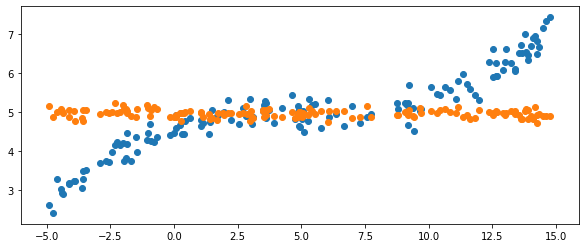

In [71]:
y_pred = ppc["out"].mean(axis=0)

plt.figure(figsize=(10, 4))
plt.scatter(x_train[:,0], y_train[:, 0])
plt.scatter(x_train[:,0], y_pred[:, 0])
plt.show()

In [57]:
ppc["out"].shape

(100, 150, 1)